In [2]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization,Conv2DTranspose, GlobalMaxPooling2D, Conv2D, Reshape
import tensorflow as tf
from tqdm import tqdm
import numpy as np

In [77]:
class GAN():

    def __init__(self,
                 n_features,
                 discriminator_structure = (16,16),
                 generator_structure = (16,16),
                 discriminator_optimizer = 'Adam',
                 generator_optimizer = 'Adam',
                 latent_dim = 1,
                 activation_discriminator = 'linear',
                 activation_generator = 'linear',
                 loss_discriminator = 'binary_crossentropy',
                 loss_generator = 'binary_crossentropy',
                 use_batch_norm_generator = False,
                 use_batch_norm_discriminator = False) -> None:

        super(GAN,self).__init__()
        self.discriminator_structure = discriminator_structure
        self.generator_structure = generator_structure
        self.latent_dim = latent_dim
        self.activation_discriminator = activation_discriminator
        self.activation_generator = activation_generator
        self.loss_discriminator = loss_discriminator
        self.loss_generator = loss_generator

        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer

        self.use_batch_norm_generator = use_batch_norm_generator
        self.use_batch_norm_discriminator = use_batch_norm_discriminator

        self.n_layers_discriminator = len(discriminator_structure)
        self.n_layers_generator = len(generator_structure)

        self.n_features = n_features

        self.generator = self.create_generator()
        self.discriminator = self.create_discriminator()
        self.compile()

        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    def create_generator(self):

        generator = Sequential(name='Generator')
        generator.add(tf.keras.layers.InputLayer(input_shape=(self.latent_dim)))
        print(self.latent_dim)

        for layer in range(self.n_layers_generator):
            generator.add(Dense(self.generator_structure[layer],
                                activation = self.activation_generator))
            if self.use_batch_norm_generator :
                generator.add(BatchNormalization())

        generator.add(Dense(self.n_features,
                            activation = self.activation_generator))

        generator.summary()

        return generator


    def create_discriminator(self):

        discriminator = Sequential(name='Discriminator')
        discriminator.add(tf.keras.layers.InputLayer(input_shape=(self.n_features)))

        for layer in range(self.n_layers_discriminator):
            discriminator.add(Dense(self.discriminator_structure[layer],
                                activation = self.activation_discriminator))
            if self.use_batch_norm_discriminator:
                discriminator.add(BatchNormalization())

        discriminator.add(Dense(1,activation='sigmoid'))
        discriminator.summary()

        return discriminator

    def compile(self):

        self.goptimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)
        self.doptimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)

        self.gloss = tf.keras.losses.BinaryCrossentropy()
        self.dloss = tf.keras.losses.BinaryCrossentropy()

    def train_step(self,inputs):
        batch_size = inputs.shape[0]
        noise = tf.random.normal((batch_size, self.latent_dim))

        # Adversarial ground truths
        valid = tf.zeros((batch_size, 1))
        fake = tf.ones((batch_size, 1))
        # Generate a batch of new data
        gen_data = self.generator.predict(noise)


        combined_data = tf.concat([inputs, gen_data], axis=0)
        combined_labels = tf.concat([valid, fake], axis=0)

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_data)
            d_loss = self.dloss(combined_labels, predictions)

        
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.doptimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Now train the generator 
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.zeros((batch_size, 1)) # train to make the discriminator fail

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise)
            predictions = self.discriminator(fake_images)
            g_loss = self.gloss(misleading_labels, predictions)

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.goptimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)

        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


    def train(self, data,epochs = 100, batch_size = 32):
        
        try :
            for ep in range(epochs) :
                tensor_data = tf.data.Dataset.from_tensor_slices(data).batch(batch_size=batch_size)
                bar = tqdm(enumerate(list(tensor_data.as_numpy_iterator())))
                for batch_id,batch_data in bar :
                    print(batch_data)
                    dic_loss = self.train_step(batch_data)
                    bar.set_description("Epoch {}, Batch {}, gloss {}, dloss {}".format(ep+1,batch_id+1,dic_loss['g_loss'],dic_loss['d_loss']))
                    break
                break
        except :
            raise ValueError('Error in the input typing')


        


In [25]:
import pandas as pd

df = pd.read_csv('./Dataset/creditcard.csv')

X_cols = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
target = 'Class'

X,y = df[X_cols], df[target]

In [61]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
data = sc.fit_transform(X[y == 1])

In [78]:
test = GAN(len(X_cols))
test.train(data)

1
Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_126 (Dense)            (None, 16)                32        
_________________________________________________________________
dense_127 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_128 (Dense)            (None, 29)                493       
Total params: 797
Trainable params: 797
Non-trainable params: 0
_________________________________________________________________
Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_129 (Dense)            (None, 16)                480       
_________________________________________________________________
dense_130 (Dense)            (None, 16)                272       
__________________________________

Epoch 1, Batch 1, gloss nan, dloss nan: : 0it [00:00, ?it/s]

[[ 3.62962725e-01 -3.89979857e-01  7.63464805e-01 -1.89563909e-01
   4.89851755e-01 -1.55199205e-02  4.21052416e-01  1.20899893e-01
  -7.56363800e-02  5.93703209e-01 -2.23530011e-01  7.22512614e-01
  -4.40357222e-01  6.27538463e-01  4.60174372e-01  7.76772114e-01
   5.50838530e-01  7.69738950e-01 -1.71426718e-01 -1.82424031e-01
  -5.07987522e-02 -3.28838286e-02 -2.69260691e-01  8.25796705e-01
   3.85522715e-03  2.67809520e-01  6.58517199e-02 -4.00455772e-01
  -4.76601769e-01]
 [ 2.55048187e-01 -1.58183314e+00  1.14331064e+00 -7.85043373e-01
   8.40511546e-01  1.79349229e-01  8.18716613e-01 -9.40122495e-02
   9.24677316e-01  9.88949059e-01 -1.57508813e+00  1.23797666e+00
   7.12197525e-01  1.23513483e+00  1.99606047e+00  1.24490934e+00
   1.04337220e+00  1.37122104e+00 -2.58283606e-01  1.28600549e+00
  -1.34249568e-02  2.82253984e-01  8.97491282e-01 -3.66317832e-01
   2.99285417e-01 -4.18102951e-01 -3.07807481e-01 -7.29842965e-02
   1.58640134e+00]
 [ 3.64272634e-01 -4.34941645e-01  9.3

In [76]:
test.train(data)

Epoch 1, Batch 1, gloss nan, dloss nan: : 0it [00:00, ?it/s]


In [131]:
test.train(x)

0it [00:00, ?it/s]

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.

Epoch 1, Batch 1, gloss nan, dloss 0.7224106788635254: : 0it [00:00, ?it/s]


In [54]:
tensor = tf.convert_to_tensor(x)
batch_tensor = tf.data.Dataset.from_tensor_slices(tensor).batch(batch_size=10)

In [59]:
batch_tensor

<BatchDataset shapes: (None, 15), types: tf.float64>

In [58]:
list(batch_tensor.as_numpy_iterator())[0].shape

(10, 15)

In [6]:
class ConditionalGAN(keras.Model):
    def __init__(self, 
                 data_type : str = 'image', 
                 number_classes : int = 10,
                 num_channels : int  = 1,
                 problem_size = (28,28),
                 discriminator_structure : tuple = (32,64),
                 generator_structure : tuple = (16,16),
                 discriminator_optimizer : str = 'Adam',
                 generator_optimizer : str = 'Adam',
                 latent_dim : int = 32,
                 activation_discriminator : str = 'linear',
                 activation_generator : str = 'linear',
                 loss : str = 'binary_crossentropy'):

        super(ConditionalGAN, self).__init__()
        self.discriminator_structure = discriminator_structure
        self.generator_structure = generator_structure
        self.latent_dim = latent_dim
        self.activation_discriminator = activation_discriminator
        self.activation_generator = activation_generator
        self.loss = loss

        self.number_classes = number_classes
        self.data_type = data_type

        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer

        self.n_layers_discriminator = len(discriminator_structure)
        self.n_layers_generator = len(generator_structure)

        self.problem_size = problem_size

        self.generator_in_channels = latent_dim + number_classes
        self.discriminator_in_channels = num_channels + number_classes

        list_prob_size = list(self.problem_size)
        list_prob_size.append(number_classes)
        self.discriminator_in_shape = tuple(list_prob_size)

        self.generator = self.create_generator()
        self.discriminator = self.create_discriminator()
        print(self.generator_in_channels, self.discriminator_in_channels)
        self.compile()

        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")



    def create_generator(self):

        print("Generating Generator Network...")

        generator = keras.Sequential(
    [
        keras.layers.InputLayer((self.generator_in_channels,)),
        keras.layers.Dense(4 * 4 * self.generator_in_channels),
        keras.layers.Reshape((4, 4, self.generator_in_channels)),
        keras.layers.UpSampling2D((2,2)),
        keras.layers.Dropout(0.5),
        keras.layers.Conv2DTranspose(self.generator_structure[0], (5, 5), strides=(1, 1), padding="valid",activation="relu"),
        keras.layers.UpSampling2D((2,2)),
        keras.layers.Dropout(0.5),
        keras.layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding="valid"),
    ],
    name="generator",
)   
        generator.summary()
        return generator
        
        generator = Sequential(name='Generator')
        generator.add(tf.keras.layers.InputLayer(input_shape=(self.generator_in_channels)))

        if self.data_type.upper() == 'IMAGE' :
            generator.add(Dense(7*7 * self.generator_in_channels,activation = self.activation_generator))
            generator.add(Reshape((7, 7, self.generator_in_channels)))
            for layer in range(self.n_layers_generator):
                generator.add(Conv2DTranspose(self.generator_structure[layer],(4,4),strides=(2, 2), padding="same",activation = self.activation_generator))
            generator.add(Conv2D(1, (7, 7), padding="same", activation="sigmoid"))
        else :
            for layer in range(self.n_layers_generator):
                generator.add(Dense(self.generator_structure[layer],
                                    activation = self.activation_generator))
                if self.use_batch_norm_generator :
                    generator.add(BatchNormalization())

            generator.add(Dense(self.n_features,
                                activation = self.activation_generator))

        generator.summary()
        return generator


    def create_discriminator(self):

        print("Generating Discriminator Network...")


        discriminator = keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(self.problem_size[0], 
                                                self.problem_size[1], 
                                                self.discriminator_in_channels)), 

        tf.keras.layers.Conv2D(self.discriminator_structure[0], (5,5), strides=(1, 1), padding="valid",activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.MaxPool2D((2,2)),

        tf.keras.layers.Conv2D(self.discriminator_structure[1], (5,5), strides=(1, 1), padding="valid",activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.MaxPool2D((2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1,activation='softmax'),
    ],
    name="Discriminator",
)
        return discriminator

        discriminator = Sequential(name='Discriminator')
        discriminator.add(tf.keras.layers.InputLayer(input_shape=(self.problem_size[0], 
                                                                  self.problem_size[1], 
                                                                  self.discriminator_in_channels)))

        if self.data_type.upper() == 'IMAGE' :
            for layer in range(self.n_layers_discriminator):
                discriminator.add(Conv2D(self.discriminator_structure[layer], (3, 3), strides=(2, 2), padding="same"))
            discriminator.add(GlobalMaxPooling2D())
        else :

            for layer in range(self.n_layers_discriminator):
                discriminator.add(Dense(self.discriminator_structure[layer],
                                    activation = self.activation_discriminator))
                if self.use_batch_norm_discriminator:
                    discriminator.add(BatchNormalization())

        discriminator.add(Dense(1))
        discriminator.summary()

        return discriminator 

        

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = keras.optimizers.Adam(learning_rate=0.0003)
        self.g_optimizer = keras.optimizers.Adam(learning_rate=0.0003)
        self.loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)


    def generate_fake(self,n_fakes,label = None):

        if label is None :
            label_vec = keras.utils.to_categorical(np.random.randint(0,self.number_classes,size = n_fakes),self.number_classes)
            noise =  tf.repeat(tf.random.normal(shape=(1, self.latent_dim)),n_fakes,axis=0)
            noise_and_labels = tf.concat([noise, label_vec], 1)

        else :
            noise =  tf.random.normal(shape=(1, self.latent_dim))
            label = keras.utils.to_categorical([label],self.number_classes)
            noise_and_labels = tf.repeat(tf.concat([noise, label], 1),n_fakes,axis=0)

        return(self.generator.predict(noise_and_labels))
        

    def train_step(self, data):

        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[self.problem_size[0] * self.problem_size[1]]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, self.problem_size[0], self.problem_size[1], self.number_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)

        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)

        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

In [7]:
batch_size = 64
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 32


# We'll use all the available examples from both the training and test
# sets.
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
all_labels = keras.utils.to_categorical(all_labels, 10)

# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {all_digits.shape}")
print(f"Shape of training labels: {all_labels.shape}")

Shape of training images: (70000, 28, 28, 1)
Shape of training labels: (70000, 10)


In [8]:
cond_gan = ConditionalGAN(num_channels = num_channels,
                          number_classes=num_classes,
                          problem_size=(image_size,image_size),
                          latent_dim=latent_dim,
                          discriminator_structure = (64,64),
                          generator_structure=(64,64))

Generating Generator Network...
Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 672)               28896     
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 42)          0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 8, 8, 42)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 42)          0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 12, 12, 64)        67264     
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)      

In [153]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

class PlotEpochCallback(keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        generate = epoch%self.model.number_classes
        print('Plot fake number {}'.format(generate))
        imshow(self.model.generate_fake(1,generate)[0])
        plt.show()

In [154]:
callbacks = [PlotEpochCallback()]

Epoch 1/100
1094/1094 [==============================] - 498s 453ms/step - g_loss: 1.5208 - d_loss: 0.3932
Plot fake number 0


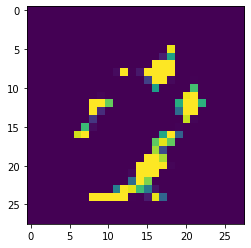

Epoch 2/100
1094/1094 [==============================] - 487s 445ms/step - g_loss: 1.4256 - d_loss: 0.4750
Plot fake number 1


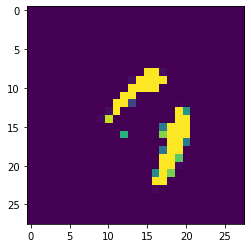

Epoch 3/100
1094/1094 [==============================] - 477s 436ms/step - g_loss: 1.2623 - d_loss: 0.5250
Plot fake number 2


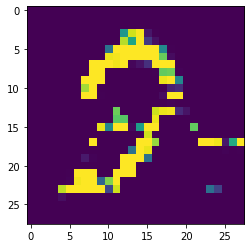

Epoch 4/100
1094/1094 [==============================] - 469s 429ms/step - g_loss: 1.2690 - d_loss: 0.5227
Plot fake number 3


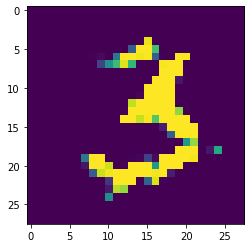

Epoch 5/100
1094/1094 [==============================] - 467s 427ms/step - g_loss: 1.2641 - d_loss: 0.5289
Plot fake number 4


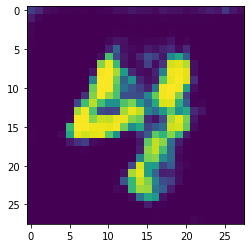

Epoch 6/100
1094/1094 [==============================] - 451s 413ms/step - g_loss: 0.8443 - d_loss: 0.6783
Plot fake number 5


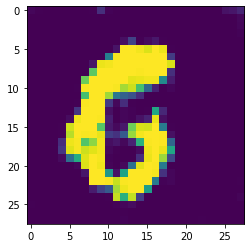

Epoch 7/100
1094/1094 [==============================] - 446s 408ms/step - g_loss: 0.8137 - d_loss: 0.6883
Plot fake number 6


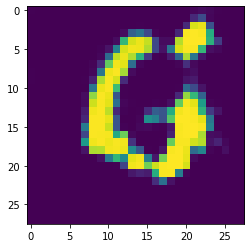

Epoch 8/100
1094/1094 [==============================] - 470s 429ms/step - g_loss: 0.7343 - d_loss: 0.7093
Plot fake number 7


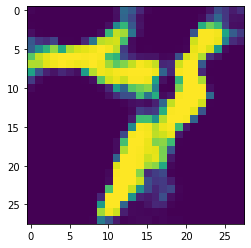

Epoch 9/100
1094/1094 [==============================] - 478s 437ms/step - g_loss: 0.7175 - d_loss: 0.6988
Plot fake number 8


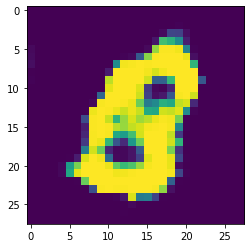

Epoch 10/100
1094/1094 [==============================] - 470s 430ms/step - g_loss: 0.7289 - d_loss: 0.7032
Plot fake number 9


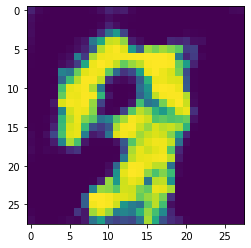

Epoch 11/100
1094/1094 [==============================] - 483s 442ms/step - g_loss: 0.7153 - d_loss: 0.6981
Plot fake number 0


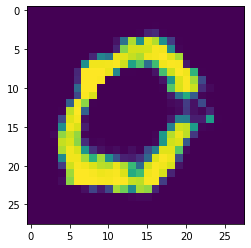

Epoch 12/100
1094/1094 [==============================] - 464s 424ms/step - g_loss: 0.7208 - d_loss: 0.6943
Plot fake number 1


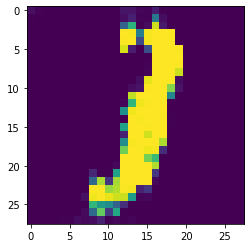

Epoch 13/100
1094/1094 [==============================] - 457s 418ms/step - g_loss: 0.7187 - d_loss: 0.6953
Plot fake number 2


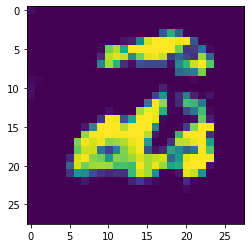

Epoch 14/100
1094/1094 [==============================] - 452s 413ms/step - g_loss: 0.7080 - d_loss: 0.7110
Plot fake number 3


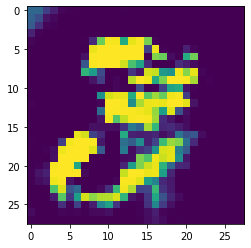

Epoch 15/100
1094/1094 [==============================] - 425s 389ms/step - g_loss: 0.7282 - d_loss: 0.6995
Plot fake number 4


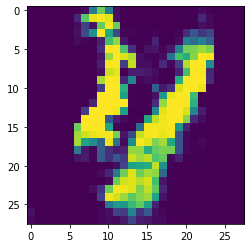

Epoch 16/100
1094/1094 [==============================] - 436s 398ms/step - g_loss: 0.7397 - d_loss: 0.6879
Plot fake number 5


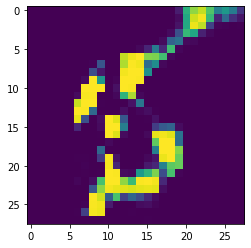

Epoch 17/100
1094/1094 [==============================] - 422s 386ms/step - g_loss: 0.7444 - d_loss: 0.6707
Plot fake number 6


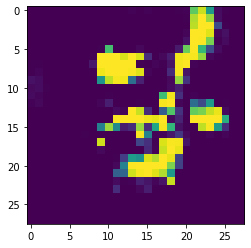

Epoch 18/100
1094/1094 [==============================] - 422s 386ms/step - g_loss: 0.7908 - d_loss: 0.6752
Plot fake number 7


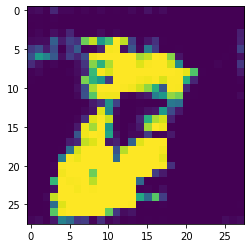

Epoch 19/100
1094/1094 [==============================] - 419s 383ms/step - g_loss: 0.7850 - d_loss: 0.6663
Plot fake number 8


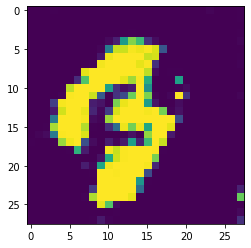

Epoch 20/100
1094/1094 [==============================] - 422s 385ms/step - g_loss: 0.8184 - d_loss: 0.6483
Plot fake number 9


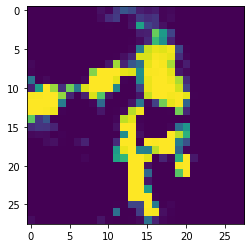

Epoch 21/100
1094/1094 [==============================] - 420s 384ms/step - g_loss: 0.7928 - d_loss: 0.6602
Plot fake number 0


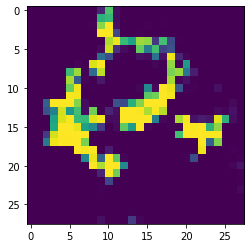

Epoch 22/100
1094/1094 [==============================] - 419s 383ms/step - g_loss: 0.8239 - d_loss: 0.6509
Plot fake number 1


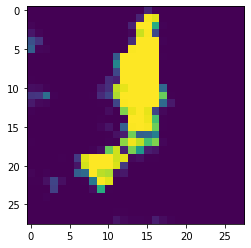

Epoch 23/100
1094/1094 [==============================] - 419s 383ms/step - g_loss: 0.8616 - d_loss: 0.6312
Plot fake number 2


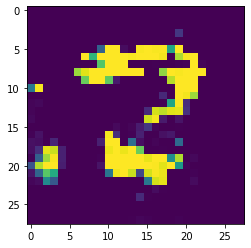

Epoch 24/100
1094/1094 [==============================] - 418s 382ms/step - g_loss: 0.8632 - d_loss: 0.6229
Plot fake number 3


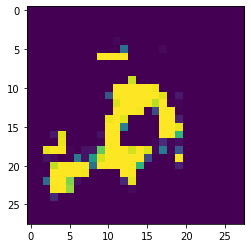

Epoch 25/100
1094/1094 [==============================] - 418s 382ms/step - g_loss: 0.9035 - d_loss: 0.5948
Plot fake number 4


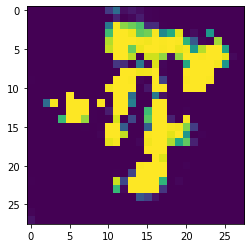

Epoch 26/100
1017/1094 [==========================>...] - ETA: 29s - g_loss: 0.9635 - d_loss: 0.5798

KeyboardInterrupt: 

In [155]:
cond_gan.fit(dataset,epochs=100,callbacks=callbacks)

In [216]:
cond_gan.discriminator.predict(cond_gan.generate_fake(1,4))

ValueError: in user code:

    C:\Users\peptr\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1569 predict_function  *
        return step_function(self, iterator)
    C:\Users\peptr\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1559 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\peptr\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\peptr\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\peptr\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\peptr\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1552 run_step  **
        outputs = model.predict_step(data)
    C:\Users\peptr\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1525 predict_step
        return self(x, training=False)
    C:\Users\peptr\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\peptr\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\input_spec.py:251 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer Discriminator is incompatible with the layer: expected axis -1 of input shape to have value 11 but received input with shape (None, 28, 28, 1)
